In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";  

import tensorflow as tf
import keras
from keras.layers import Dense, Flatten
from keras.layers import MaxPooling2D, Dropout, Conv2D, Activation
import numpy as np
import numpy.random as random
import pylab as plt
from keras.datasets import mnist, cifar10
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from sklearn import svm
import time
from datetime import datetime
import matplotlib

Using TensorFlow backend.


In [2]:
##
## Information Computations
##

# estimate I(M(x); y | L(x))
def estimate_IMYL(model, linModel, x, y):
    p = est_density(model, linModel, x, y)
    return I_XYZ(p)

def est_density_MYL(model, linModel, x, y):
    Mx = np.round(model.predict(x)).flatten()
    Lx = np.round(linModel.predict(x)).flatten()
    y = y.flatten()
    
    p = est_density(Mx, y, Lx)
    return p
    
def est_density(X, Y, Z): # estimate p[x,y,z] \in R^{{0,1}^3} for samples from X, Y, Z \in \N
    X = X.astype(int)
    Y = Y.astype(int)
    Z = Z.astype(int)
    
    n = len(X)
    p = np.zeros((2, 2, 2)) # p[x,y,z] is the joint prob density
    for i in range(n):
        p[X[i], Y[i], Z[i]] += 1.0
    p /= n
    return p

def I_XYZ(p): # compute I(X, Y | Z) for joint density p[x, y, z]
    pz = np.sum(p, axis=(0,1), keepdims=True) # the density of z. pz[x,y,z] = p(z)
    
    p_xy_z = p / pz  # q[x, y, z] = p(x, y | z)
    p_x_z =  np.sum(p, axis=1, keepdims=True) / pz  # p(x | z)
    p_y_z =  np.sum(p, axis=0, keepdims=True) / pz  # p(y | z)
    
    I = np.sum(p * np.nan_to_num(np.log2( p_xy_z / (p_x_z * p_y_z) )))
    return I


# returns I(A; B) where A, B \in {X, Y, Z} spefice by idx
# eg, I(X; Y) = I_ab(p, idx=[0, 1])
#     I(X; Z) = I_ab(p, idx=[0, 2])
def I_ab(p, idx=(0,1)): 
    exlude = (0+1+2) - np.sum(idx)
    p_ab = np.sum(p, axis=exlude)
    p_a = np.sum(p_ab, axis=1, keepdims=True)
    p_b = np.sum(p_ab, axis=0, keepdims=True)
    
    I = np.sum(p_ab * np.nan_to_num(np.log2( p_ab / (p_a * p_b) )))
    return I

def H(q): # binary entropy
    return -q*np.log2(q) - (1-q)*np.log2(1-q)


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('data/cnn2-0.csv')
sgd_steps = df.values[:, 1]
I_MYG0 = df.values[:, 2]
df = pd.read_csv('data/cnn2-1.csv')
I_MYG1 = df.values[:, 2]
df = pd.read_csv('data/cnn2-2.csv')
I_MYG2 = df.values[:, 2]
df = pd.read_csv('data/cnn2-3.csv')
I_MYG3 = df.values[:, 2]
I_MYG_CNN2 = np.c_[I_MYG0, I_MYG1, I_MYG2, I_MYG3].T

In [5]:
df = pd.read_csv('data/cnn4-0.csv')
sgd_steps = df.values[:, 1]
I_MYG0 = df.values[:, 2]
df = pd.read_csv('data/cnn4-1.csv')
I_MYG1 = df.values[:, 2]
df = pd.read_csv('data/cnn4-2.csv')
I_MYG2 = df.values[:, 2]
df = pd.read_csv('data/cnn4-3.csv')
I_MYG3 = df.values[:, 2]
I_MYG_CNN4 = np.c_[I_MYG0, I_MYG1, I_MYG2, I_MYG3].T

In [6]:
df = pd.read_csv('data/cnn6-0.csv')
sgd_steps = df.values[:, 1]
I_MYG0 = df.values[:, 2]
df = pd.read_csv('data/cnn6-1.csv')
I_MYG1 = df.values[:, 2]
df = pd.read_csv('data/cnn6-2.csv')
I_MYG2 = df.values[:, 2]
df = pd.read_csv('data/cnn6-3.csv')
I_MYG3 = df.values[:, 2]
I_MYG_CNN6 = np.c_[I_MYG0, I_MYG1, I_MYG2, I_MYG3].T

In [7]:
df = pd.read_csv('data/resnet-0.csv')
I_MY0 = df.values[:, 2]
df = pd.read_csv('data/resnet-1.csv')
I_MY1 = df.values[:, 2]
df = pd.read_csv('data/resnet-2.csv')
I_MY2 = df.values[:, 2]
df = pd.read_csv('data/resnet-3.csv')
I_MY3 = df.values[:, 2]
I_MY = np.c_[I_MY0, I_MY1, I_MY2, I_MY3].T

In [8]:
df = pd.read_csv('data/resnet-train-0.csv')
I_MY0 = df.values[:, 2]
df = pd.read_csv('data/resnet-train-1.csv')
I_MY1 = df.values[:, 2]
df = pd.read_csv('data/resnet-train-2.csv')
I_MY2 = df.values[:, 2]
df = pd.read_csv('data/resnet-train-3.csv')
I_MY3 = df.values[:, 2]
I_MY_train = np.c_[I_MY0, I_MY1, I_MY2, I_MY3].T

In [9]:
I_MYG.shape

NameError: name 'I_MYG' is not defined

<Figure size 7200x4800 with 0 Axes>

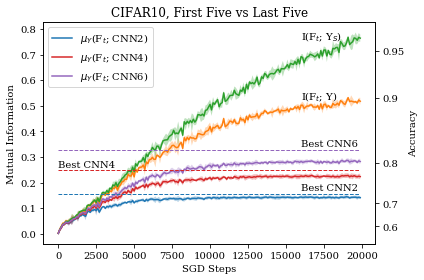

In [13]:
gap2 = I_MY - I_MYG_CNN2
gap4 = I_MY - I_MYG_CNN4
gap6 = I_MY - I_MYG_CNN6
# gap = gap[ np.newaxis,...]
# I_MY = I_MY[np.newaxis,...]
# _, lin_acc = lin.evaluate(x_test, y_test)

plt.figure(dpi=1200)
plt.rcParams["font.family"] = 'serif'

eps = sgd_steps
fig, ax1 = plt.subplots()
# ax1.set_xscale('log',basex=1.1)


ax1.plot(eps, gap2.mean(axis=0), label='$\mu_Y$(F$_t$; CNN2)')
ax1.fill_between(eps, gap2.mean(axis=0)-gap2.std(axis=0), gap2.mean(axis=0)+gap2.std(axis=0), alpha=0.3)

ax1.plot(eps, I_MY.mean(axis=0)) #, label='I(F$_t$; Y)')
ax1.fill_between(eps, I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.3)

ax1.plot(eps, I_MY_train.mean(axis=0))#, label='I(F$_t$; Y$_S$)')
ax1.fill_between(eps, I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.3)


ax1.plot(eps, gap4.mean(axis=0), label='$\mu_Y$(F$_t$; CNN4)')
ax1.fill_between(eps, gap4.mean(axis=0)-gap4.std(axis=0), gap4.mean(axis=0)+gap4.std(axis=0), alpha=0.3)


ax1.plot(eps, gap6.mean(axis=0), label='$\mu_Y$(F$_t$; CNN6)')
ax1.fill_between(eps, gap6.mean(axis=0)-gap6.std(axis=0), gap6.mean(axis=0)+gap6.std(axis=0), alpha=0.3)


leg2 = ax1.plot(eps, best2*np.ones_like(eps), linestyle='--', linewidth=1, color='C0')
leg4 = ax1.plot(eps, best4*np.ones_like(eps), linestyle='--', linewidth=1, color='C3')
leg6 = ax1.plot(eps, best6*np.ones_like(eps), linestyle='--', linewidth=1, color='C4')

plt.text(eps[-40], best2+0.015, 'Best CNN2')
plt.text(eps[0], best4+0.01, 'Best CNN4')
plt.text(eps[-40], best6+0.015, 'Best CNN6')

plt.text(eps[-40], I_MY.mean(axis=0)[-38]+0.035, 'I(F$_t$; Y)')
plt.text(eps[-40], I_MY_train.mean(axis=0)[-38]+0.09, 'I(F$_t$; Y$_S$)')
# plt.text(eps[0], best6+0.01, 'CNN6')

# first_legend = plt.legend(handles=leg2, loc=1)
# ax1.add_artist(first_legend)
# second_legend = plt.legend(handles=leg4, loc=2)
# ax1.add_artist(second_legend)



plt.xlabel("SGD Steps")
plt.ylabel("Mutual Information")
# plt.grid(True, axis='y')
# plt.semilogx(eps, np.log2(eps))

ax1.legend()
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

# l = ax1.get_ylim()
# l2 = ax2.get_ylim()
labels = np.array([0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, First Five vs Last Five')

labels = np.linspace(0.5, 1, 6)



# ax2.set_yticks(ytx2)
fig.tight_layout()

plt.savefig('tristan_plot.pdf')


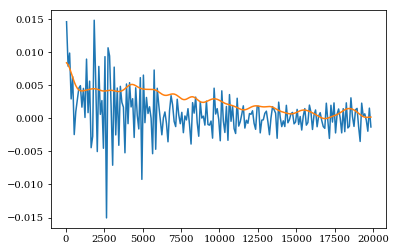

In [215]:
y_p = np.diff(gap2.mean(axis=0))
x_p = (np.array(eps)[:-1] + np.array(eps)[1:]) / 2

# from scipy.ndimage.filters import gaussian_filter1d

# ysmoothed = gaussian_filter1d(y_p, sigma=4)
plt.plot(x_p, y_p)
plt.plot(x_p, ysmoothed)
plt.show()

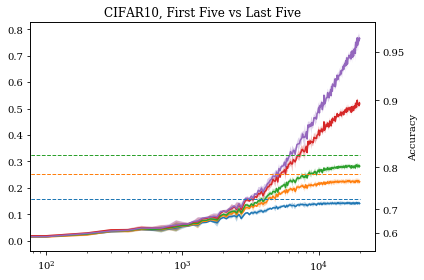

In [242]:
fig, ax1 = plt.subplots()
ax1.set_xscale('log',basex=10)

ax1.plot(eps, gap2.mean(axis=0), label='$\mu_Y$(F$_t$; CNN2)')
ax1.fill_between(eps, gap2.mean(axis=0)-gap2.std(axis=0), gap2.mean(axis=0)+gap2.std(axis=0), alpha=0.3)


ax1.plot(eps, gap4.mean(axis=0), label='$\mu_Y$(F$_t$; CNN4)')
ax1.fill_between(eps, gap4.mean(axis=0)-gap4.std(axis=0), gap4.mean(axis=0)+gap4.std(axis=0), alpha=0.3)


ax1.plot(eps, gap6.mean(axis=0), label='$\mu_Y$(F$_t$; CNN6)')
ax1.fill_between(eps, gap6.mean(axis=0)-gap6.std(axis=0), gap6.mean(axis=0)+gap6.std(axis=0), alpha=0.3)

ax1.plot(eps, I_MY.mean(axis=0)) #, label='I(F$_t$; Y)')
ax1.fill_between(eps, I_MY.mean(axis=0)-I_MY.std(axis=0), I_MY.mean(axis=0)+I_MY.std(axis=0), alpha=0.3)

ax1.plot(eps, I_MY_train.mean(axis=0))#, label='I(F$_t$; Y$_S$)')
ax1.fill_between(eps, I_MY_train.mean(axis=0)-I_MY_train.std(axis=0), I_MY_train.mean(axis=0)+I_MY_train.std(axis=0), alpha=0.3)

leg2 = ax1.plot(eps, best2*np.ones_like(eps), linestyle='--', linewidth=1, color='C0')
leg4 = ax1.plot(eps, best4*np.ones_like(eps), linestyle='--', linewidth=1, color='C1')
leg6 = ax1.plot(eps, best6*np.ones_like(eps), linestyle='--', linewidth=1, color='C2')

ax2 = ax1.twinx()
ax2.plot(ax1.get_ylim(), alpha=0)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(ax1.get_ylim())

labels = np.array([0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
# f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
# ticks = f(1-H(labels))
ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(1-H(labels)))
ax2.set_yticklabels(labels)
plt.title('CIFAR10, First Five vs Last Five')

labels = np.linspace(0.5, 1, 6)

fig.tight_layout()


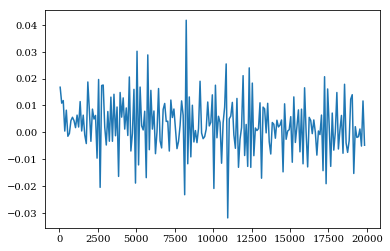

In [207]:
plt.plot(x_p, y_p)

In [198]:
np.diff(eps)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 10

In [117]:
leg2

In [67]:
gap.shape

(200, 2)

In [11]:
best6 = np.average([0.3332782983779907, 0.3245275020599365,  0.3306088447570801, 0.3165706992149353])
best4 = np.average([0.26430124044418335,
0.2548440098762512,
0.2388744354248047,
0.24545720219612122])
best2 = np.average([0.14503133296966553,
0.1611364185810089,
0.15932519733905792,
0.1610892415046692])


In [56]:
gap.shape

(200,)

In [34]:
range(eps)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [35]:
gap.mean(axis=0),

(0.11661570116644725,)

In [41]:
def I(p):
    return 1 - H(p)

Text(0,0.5,'Mutual Information')

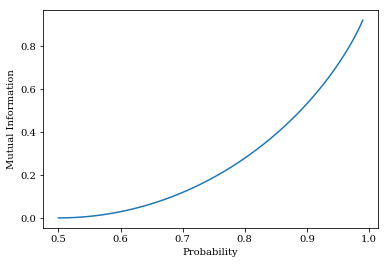

In [46]:
x = np.linspace(0.5, 0.99, 100)
plt.plot(x, I(x))
plt.xlabel('Probability')
plt.ylabel('Mutual Information')